# Notebook Imports

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# TensorFlow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

2024-10-24 15:41:46.901381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 15:41:46.901526: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 15:41:47.032486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

## Constants

In [3]:
FILE = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'

# Step 1: Data Collection and Loading

* Large Movie Review Dataset [Link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

In [4]:
data = pd.read_csv(FILE)
df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# df = df_full.sample(frac=1)
df.head()

,review,sentiment
0,A wonderful little production. <br /><br />The...,positive
1,I thought this was a wonderful way to spend ti...,positive
2,Basically there's a family where a little boy ...,negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     49999 non-null  object
 1   sentiment  49999 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
print(f"The empty row in the data: \n{df.isnull().sum()}")

The empty row in the data: 
review       0
sentiment    0
dtype: int64


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")


The shape of the data: (49999, 2)

The types of the data: 
review       object
sentiment    object
dtype: object



# Step 2: Data Preprocessing

* **Text Cleaning:** Remove any HTML tags, special characters, numbers, and other non-alphabetic characters.
* **Tokenization:** Split the reviews into individual words (tokens).
* **Stop Words Removal:** Remove common words that do not contribute to the sentiment, such as 'and', 'the', 'is', etc.
* **Lemmatization:** Reduce words to their base or root form.

### Text Cleaning

In [8]:
df.nunique()

review       49581
sentiment        2
dtype: int64

In [9]:
df = df.drop_duplicates()
print(df.shape)
df.head()

(49581, 2)


,review,sentiment
0,A wonderful little production. <br /><br />The...,positive
1,I thought this was a wonderful way to spend ti...,positive
2,Basically there's a family where a little boy ...,negative
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [10]:
# remove html tags from text
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

### Tokenization, Stop Words Removal, Lemmatization

In [11]:
def clean_review(text, wl=WordNetLemmatizer(), 
               stop_words=set(stopwords.words('english'))):
    # Remove HTML tags
    cleaned_text = remove_html_tags(text)
    
    # Converts to lower case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Remove the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(wl.lemmatize(word))
    
    filtered_words = ' '.join(filtered_words)    
     
    return filtered_words

In [12]:
%%time
nested_list = df.review.apply(clean_review)
df['review'] = nested_list

CPU times: user 2min 56s, sys: 198 ms, total: 2min 56s
Wall time: 2min 56s


In [13]:
df.head()

,review,sentiment
0,wonderful little production filming technique ...,positive
1,thought wonderful way spend time hot summer we...,positive
2,basically family little boy jake think zombie ...,negative
3,petter mattei love time money visually stunnin...,positive
4,probably favorite movie story selflessness sac...,positive


In [14]:
nested_list.head()

0    wonderful little production filming technique ...
1    thought wonderful way spend time hot summer we...
2    basically family little boy jake think zombie ...
3    petter mattei love time money visually stunnin...
4    probably favorite movie story selflessness sac...
Name: review, dtype: object

In [15]:
# Convert labels to binary (0 and 1)
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

### Positive and Negative Words

In [16]:
# Identify the index of positive review
ids_positive = df[df.sentiment == 1].index
ids_positive

Index([    0,     1,     3,     4,     5,     8,    13,    15,    17,    19,
       ...
       49967, 49975, 49976, 49977, 49979, 49982, 49984, 49988, 49991, 49994],
      dtype='int64', length=24883)

In [17]:
# Identify the index of negative review
ids_negative = df[df.sentiment == 0].index
ids_negative

Index([    2,     6,     7,     9,    10,    11,    12,    14,    16,    18,
       ...
       49981, 49986, 49987, 49989, 49992, 49993, 49995, 49996, 49997, 49998],
      dtype='int64', length=24698)

In [18]:
nested_list_positive = nested_list.loc[ids_positive]
nested_list_negative = nested_list.loc[ids_negative]

nested_list_positive.shape, nested_list_negative.shape

((24883,), (24698,))

In [19]:
list_positive = [item for sublist in nested_list_positive for item in sublist.split(" ")]
positive_words = pd.Series(list_positive).value_counts()

list_negative = [item for sublist in nested_list_negative for item in sublist.split(" ")]
negative_words = pd.Series(list_negative).value_counts()

positive_words.shape[0], negative_words.shape[0]

(65556, 62902)

In [20]:
positive_words[:10]

film         48026
movie        43229
one          27004
like         17555
time         15242
good         14442
story        13677
character    13633
great        12695
see          12505
Name: count, dtype: int64

In [21]:
negative_words[:10]

movie        55708
film         41684
one          25562
like         22064
would        15043
even         14881
time         14136
good         14110
bad          13988
character    13860
Name: count, dtype: int64

# Step 3: Exploratory Data Analysis (EDA)

* Visualize the distribution of reviews by sentiment (positive vs. negative)
* Analyze the most common words in positive and negative reviews

In [22]:
amount_of_positive_review = df.sentiment.value_counts()[1]
amount_of_negative_review = df.sentiment.value_counts()[0]

amount_of_positive_review, amount_of_negative_review

(24883, 24698)

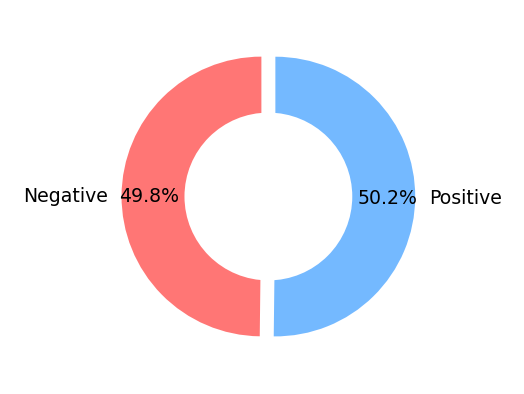

In [23]:
categoty_names = ['Negative', 'Positive']
sizes = [amount_of_negative_review, amount_of_positive_review]
custom_colours = ['#ff7675', '#74b9ff']
offset = [0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=categoty_names, textprops={'fontsize': 6}, startangle=90,
       autopct='%1.1f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

#draw a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

### Word Cloud of Positive and Negative Reviews

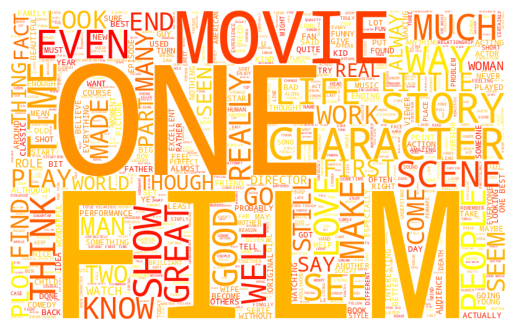

In [24]:
# Generate the text as a string for the Word Cloud
positive_str = ' '.join(list_positive)

wc = WordCloud(background_color='white', max_words=1000, colormap='autumn', width=800, height=500)
wc.generate(positive_str.upper())
plt.axis("off")
plt.imshow(wc)

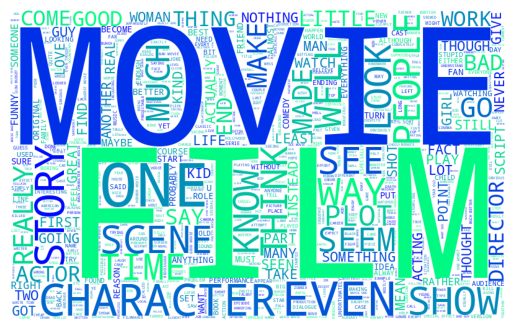

In [25]:
# Generate the text as a string for the Word Cloud
negative_str = ' '.join(list_negative)

wc = WordCloud(background_color='white', max_words=1000, colormap='winter', width=800, height=500)
wc.generate(negative_str.upper())
plt.axis("off")
plt.imshow(wc)

# Step 4: Model Preparation

In [26]:
max_length = max(len(sublist) for sublist in nested_list)
print(max_length)

9011


In [27]:
df.reset_index()
df.head()

,review,sentiment
0,wonderful little production filming technique ...,1
1,thought wonderful way spend time hot summer we...,1
2,basically family little boy jake think zombie ...,0
3,petter mattei love time money visually stunnin...,1
4,probably favorite movie story selflessness sac...,1


In [28]:
data_dict = {
    "Preprocessed Review": df['review'],
    "Target": df['sentiment']
}

df_prep = pd.DataFrame(data_dict)
df_prep.head()

,Preprocessed Review,Target
0,wonderful little production filming technique ...,1
1,thought wonderful way spend time hot summer we...,1
2,basically family little boy jake think zombie ...,0
3,petter mattei love time money visually stunnin...,1
4,probably favorite movie story selflessness sac...,1


In [29]:
count_vect = CountVectorizer(ngram_range=(1, 2))        
transformer = TfidfTransformer(norm='l2', sublinear_tf=True)
counts = count_vect.fit_transform(df_prep['Preprocessed Review'])

X = transformer.fit_transform(counts)
y = np.array(df_prep['Target'].values, dtype='float64')

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39664, 2875435), (9917, 2875435), (39664,), (9917,))

In [31]:
LABELS = ['Negative', 'Positive']

In [32]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    Plots a confusion matrix using the true and predicted labels.

    Args:
        y_true (array-like): The true labels.
        y_pred (array-like): The predicted labels.
        labels (array-like): The list of labels to index the matrix.
    """
    
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Step 5: Basic Model Implementation

## Logistic Regression

In [33]:
%%time
logreg = LogisticRegression(random_state=42, solver="saga")

logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

CPU times: user 8.31 s, sys: 76.9 ms, total: 8.39 s
Wall time: 8.39 s


In [34]:
accuracy_score(y_test, y_pred_lr)

0.8844408591307855

In [35]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      4919
         1.0       0.87      0.91      0.89      4998

    accuracy                           0.88      9917
   macro avg       0.89      0.88      0.88      9917
weighted avg       0.89      0.88      0.88      9917



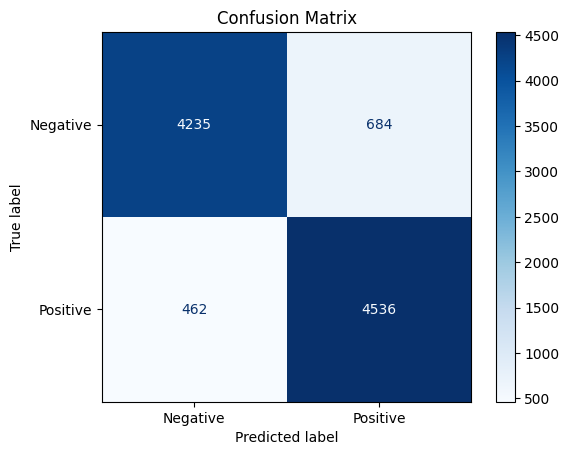

In [36]:
plot_confusion_matrix(y_test, y_pred_lr, LABELS)

## Random Forest

In [37]:
%%time
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_rf = model.predict(X_test)

CPU times: user 34min 46s, sys: 738 ms, total: 34min 47s
Wall time: 34min 46s


In [38]:
accuracy_score(y_test, y_pred_rf)

0.8512655036805485

In [39]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85      4919
         1.0       0.84      0.87      0.86      4998

    accuracy                           0.85      9917
   macro avg       0.85      0.85      0.85      9917
weighted avg       0.85      0.85      0.85      9917



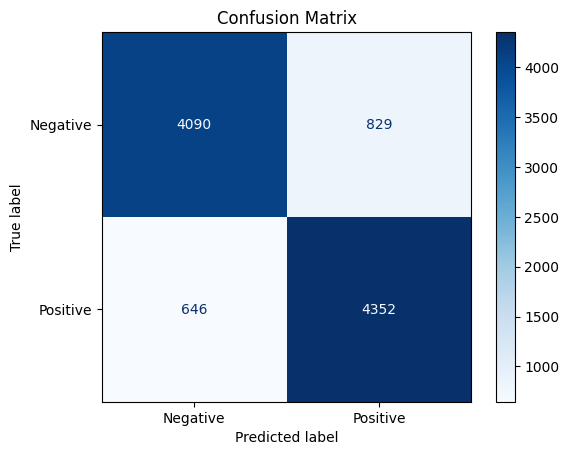

In [40]:
plot_confusion_matrix(y_test, y_pred_rf, LABELS)

## Support Vector Machines

In [41]:
%%time
from sklearn.svm import SVC  

clf = SVC(kernel='linear') 
 
# fitting x samples and y classes 
clf.fit(X_train, y_train) 
y_pred_clf = clf.predict(X_test)

CPU times: user 1h 4min 2s, sys: 1.06 s, total: 1h 4min 3s
Wall time: 1h 4min 2s


In [42]:
accuracy_score(y_test, y_pred_clf)

0.9040032267822931

In [43]:
print(classification_report(y_test, y_pred_clf))

              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      4919
         1.0       0.89      0.92      0.91      4998

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



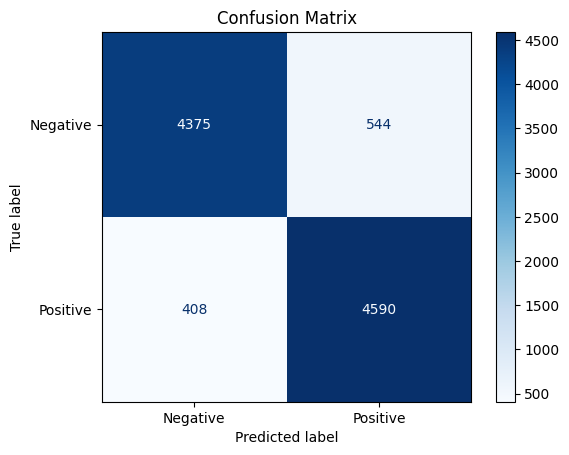

In [44]:
plot_confusion_matrix(y_test, y_pred_clf, LABELS)

# Advanced Model Implementations

### Tokenization and padding

In [45]:
# Tokenization and padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review'])
X = pad_sequences(tokenizer.texts_to_sequences(df['review']), maxlen=1000)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### DataLoader for Training and Testing

In [46]:
# Define custom dataset class for PyTorch
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader for training and testing
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Hyperparameters

In [47]:
# Hyperparameters
vocab_size = 10000
embed_size = 512
hidden_size = 256
output_size = 1
num_layers = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 15

## LSTM: Long-Short-Term Memory model in PyTorch

In [48]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        h_lstm, (h_n, c_n) = self.lstm(x)
        out = h_lstm[:, -1, :] 
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

# Model, Loss function, and Optimizer
model = LSTMModel(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### Train the Model

In [49]:
%%time
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/15], Loss: 0.4777
Epoch [2/15], Loss: 0.2998
Epoch [3/15], Loss: 0.2350
Epoch [4/15], Loss: 0.1872
Epoch [5/15], Loss: 0.1443
Epoch [6/15], Loss: 0.1014
Epoch [7/15], Loss: 0.0677
Epoch [8/15], Loss: 0.0464
Epoch [9/15], Loss: 0.0403
Epoch [10/15], Loss: 0.0314
Epoch [11/15], Loss: 0.0340
Epoch [12/15], Loss: 0.0257
Epoch [13/15], Loss: 0.0184
Epoch [14/15], Loss: 0.0158
Epoch [15/15], Loss: 0.0133
CPU times: user 24min 34s, sys: 6min 25s, total: 30min 59s
Wall time: 31min


### Test the Model

In [50]:
%%time
# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = (outputs.squeeze() > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8779
CPU times: user 9.29 s, sys: 2.17 s, total: 11.5 s
Wall time: 11.5 s


## Development Environment Specifications

In [51]:
# OS Information
!cat /etc/os-release

# Memory Information
!free -h

# GPU Information
!nvidia-smi

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


NAME="Ubuntu"
VERSION="20.04.6 LTS (Focal Fossa)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 20.04.6 LTS"
VERSION_ID="20.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=focal
UBUNTU_CODENAME=focal
              total        used        free      shared  buff/cache   available
Mem:           31Gi       4.1Gi        20Gi        16Mi       7.2Gi        26Gi
Swap:            0B          0B          0B
Thu Oct 24 17:56:56 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   